<a href="https://colab.research.google.com/github/ikram-hamizi/AML-DS-2021/blob/main/AML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Innopolis University - Spring 2021
- **Student**: Ikram Hamizi
- **Professor**: Muhammad Fahim
- **Teaching Assistant**: ‪Gcinizwe Dlamini‬
- **Homework (2) Task**: Collaborative Filtering for Recommender Systems [Link](https://hackmd.io/@gFZmdMTOQxGFHEFqqU8pMQ/B1z1pP6L_)

##Data Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d9661d3b4e70138fcc603a5111271c5ce04de4dc158b0d2e730a0f870fee483e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import wget
from zipfile import ZipFile
from sklearn.metrics import mean_squared_error

# Setting the environment
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [4]:
# Download the data
wget.download("https://github.com/Gci04/AML-DS-2021/raw/main/data/collaborative-filtering.zip")

with ZipFile("collaborative-filtering.zip", 'r') as f:
  f.extractall()

In [5]:
# Read the data
train = pd.read_csv("collaborative-filtering/train.csv")
test = pd.read_csv("collaborative-filtering/test.csv")

train.head()

,userId,movieId,rating
0,1,32,3.5
1,1,47,3.5
2,1,50,3.5
3,1,253,4.0
4,1,260,4.0


In [6]:
# Print important information
unique_users = train['userId'].unique()
unique_movies = train['movieId'].unique()

U = len(unique_users)
I = len(unique_movies) 
print("Number of unique users: ", U)
print("Number of unique movies: ", I)
print("Length of the dataset: ", len(train))
print("Length of the sparse matrix: ", U*I) #UxI

Number of unique users:  6687
Number of unique movies:  5064
Length of the dataset:  761972
Length of the sparse matrix:  33862968


In [7]:
known_ratings_percentage = 100*(len(train))/(U*I)
print(f"The percentage of known ratings: θ% = {known_ratings_percentage}%")

The percentage of known ratings: θ% = 2.2501630689902905%


Text(0.5, 1.0, 'Histogram of ratings frequency (binned)')

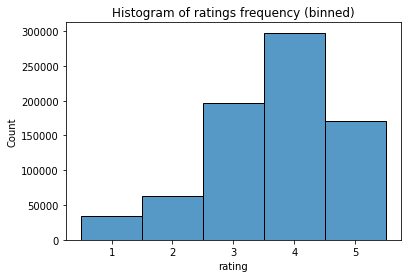

In [8]:
# Print the histogram
sns.histplot(data=train, x="rating", binwidth=1).set_title("Histogram of ratings frequency (binned)")



---


#1. Collaborative Filtering model: **Matrix Factorization**


In [9]:
# TRAINING SET: Get the the user-item matrix (dense)
df_movie_features = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)
df_movie_features.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,106002,106072,106100,106487,106489,106642,106696,106766,106782,106916,106918,106920,107141,107406,108190,108932,109374,109487,110102,110553,110730,111360,111362,111364,111659,111759,112138,112175,112183,112290,112552,112556,112623,112852,114180,115569,115617,116797,116823,118696
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# TESTING SET: Get the the user-item matrix (dense)
df_movie_features_test = test.pivot(index='userId', columns='movieId', values='rating').fillna(0)
df_movie_features_test.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,106002,106072,106100,106487,106489,106642,106696,106766,106782,106916,106918,106920,107141,107406,108190,108932,109374,109487,110102,110553,110730,111360,111362,111364,111659,111759,112138,112175,112183,112290,112552,112556,112623,112852,114180,115569,115617,116797,116823,118696
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_movie_features_test.shape, df_movie_features.shape
# The sahpes are not equal. There are missing userId's and movieId's

((6674, 5059), (6687, 5064))

In [12]:
# 1. Add missing userId's and movieId's to the test set
df_movie_features_test = df_movie_features_test.reindex(columns=df_movie_features_test.columns | df_movie_features.columns, index=df_movie_features_test.index | df_movie_features.index)

# Fill the NaN values with 0's
df_movie_features_test = df_movie_features_test.fillna(0)

# 2. Assert that the training set and the test set are disjoint
assert np.all(df_movie_features_test.values * df_movie_features.values == 0)

In [13]:
#ratings dense matrix
Y = df_movie_features.values
Y_test = df_movie_features_test.values

unique_users = train['userId'].unique() #6687 
unique_movies = train['movieId'].unique() #5064

U = len(unique_users)
I = len(unique_movies)

C = 0.02 #Regularization parameter.
k = 50

###**1.1 ALS OPTIMIZATION METHOD**

*Note*: The algorithm for ALS is slightly modified in this image to show the closed form equations using matrices.

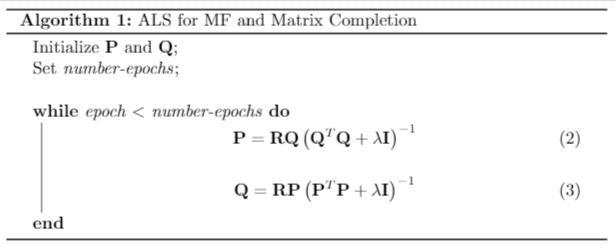

In [225]:
def ALS(movie_features, fixed_matrix, k, C):
  """
  args:
    movie_features: the User-Item matrix (R)
    fixed_matrix: the fixed latent matrix (use P if updating Q and vice versa)
    k: number of factors in latent vectors
    C: Regularization parameter

  return:
    updated matrix after ALS
  
  e.g.: P = R*Q*(Q.T*Q + λ*I)^{-1}
  """  
  updated_matrix = movie_features @ fixed_matrix @ np.linalg.inv(fixed_matrix.T @ fixed_matrix + C * np.eye(k))
  return updated_matrix

**Loss Function with L2 Regularization** 

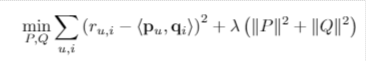

In [224]:
def RMSE(error, A, B, C=0): 
        
  squared_magnitude_P = (A @ A.T).sum()
  squared_magnitude_Q = (B @ B.T).sum()

  regularization = C*(squared_magnitude_P + squared_magnitude_Q)
  loss = ((error**2).sum() + regularization)/(total_ratings) #total_ratings |u,i| is the total number of ratings in the dataset.
  loss = np.sqrt(loss)                                                                   

  return loss

In [223]:
train_mask = np.nonzero(Y)
test_mask = np.nonzero(Y_test)

def error_with_mask(Y, Y_pred, dataset):
  """returns the difference between Y and Y_pred, i.e. error or deviance"""
  if dataset == 'train':
    mask = train_mask
  elif dataset == 'test':
    mask = test_mask
  else:
    return
  error = Y[mask] - Y_pred[mask]
  return error

In [226]:
n_epochs = 100

#user latent matrix
P = np.random.uniform(0, 1/np.sqrt(k), (U,k))

#item latent matrix
Q = np.random.uniform(0, 1/np.sqrt(k), size=(I,k))

train_losses = []
test_losses = []

for epoch in range(n_epochs):

      P = ALS(Y, Q, k, C)
      Q = ALS(Y.T, P, k, C)

      Y_pred = (P @ Q.T)
      
      train_error = error_with_mask(Y, Y_pred, dataset='train')
      test_error = error_with_mask(Y_test, Y_pred, dataset='test')

      train_LOSS = RMSE(train_error, P, Q, C)
      test_LOSS = RMSE(test_error, P, Q)

      train_losses.append(train_LOSS)
      test_losses.append(test_LOSS)

      if (epoch==0 or (epoch+1)%10 == 0):
        print(f"\nEpoch: {epoch+1}/{n_epochs}")
        print(f"Train LOSS (λ={C}) = {train_LOSS}, (λ=0) = {mean_squared_error(Y[Mask],Y_pred[Mask], squared=False)}") # mean_squared_error for DEBUGGING
        print(f"Test  LOSS    (λ=0) = {test_LOSS}")


Epoch: 1/100
Train LOSS (λ=0.02) = 2.909666659327918, (λ=0) = 2.8498758519173695
Test  LOSS    (λ=0) = 1.515410236150164

Epoch: 10/100
Train LOSS (λ=0.02) = 2.5850817746487493, (λ=0) = 2.5106132469331373
Test  LOSS    (λ=0) = 1.3982769543628584

Epoch: 20/100
Train LOSS (λ=0.02) = 2.5833251486962623, (λ=0) = 2.5091693722305104
Test  LOSS    (λ=0) = 1.3979024380068057

Epoch: 30/100
Train LOSS (λ=0.02) = 2.5828938427878083, (λ=0) = 2.5088969056587844
Test  LOSS    (λ=0) = 1.3977037438877267

Epoch: 40/100
Train LOSS (λ=0.02) = 2.5827021114853825, (λ=0) = 2.5088375680988424
Test  LOSS    (λ=0) = 1.397745206286871

Epoch: 50/100
Train LOSS (λ=0.02) = 2.5825632834152317, (λ=0) = 2.5088306710516344
Test  LOSS    (λ=0) = 1.3978447793857949

Epoch: 60/100
Train LOSS (λ=0.02) = 2.582422532143987, (λ=0) = 2.5088231788710362
Test  LOSS    (λ=0) = 1.3978899258497262

Epoch: 70/100
Train LOSS (λ=0.02) = 2.5822751233996017, (λ=0) = 2.508808414181609
Test  LOSS    (λ=0) = 1.3978881426411174

Epoch

In [234]:
als_matrix = P @ Q.T
np.min(als_matrix), np.max(als_matrix) # ????? LAB8 has also weird min and max

(-11.394401547409695, 11.261478699885803)

###**1.2 GRADIENT DESCENT OPTIMIZATION METHOD**

In [228]:
def RMSE(error, A, B, C=0, bu=None, bi=None): 
        
  squared_magnitude_P = (A @ A.T).sum()
  squared_magnitude_Q = (B @ B.T).sum()

  squared_magnitude_bu = 0
  squared_magnitude_bi = 0

  if (bu is not None and bi is not None):
    squared_magnitude_bu = (bu @ bu.T).sum()
    squared_magnitude_bi = (bi @ bi.T).sum()

  regularization = C*(squared_magnitude_P + squared_magnitude_Q + squared_magnitude_bu + squared_magnitude_bi)
  loss = ((error**2).sum() + regularization)/(total_ratings)
  loss = np.sqrt(loss)                                                                   

  return loss

In [240]:
# M: is the indicator mask
# m_{ui} = 1 if user u has rated the item i , 0 otherwise
M_train = df_movie_features.values.copy()
M_train[M_train>0] = 1

M_test = df_movie_features_test.values.copy()
M_test[M_test>0] = 1

n_epochs = 50
lr = 0.02

#user latent matrix
P2 = (6/k) * np.random.random(size=(U,k))

#item latent matrix
Q2 = (6/k) * np.random.random(size=(I,k))

#mu: overall average rating
mu = np.mean(ratings) #overallAverageRating

#bi: item (movie) average offset
#bi = mu - Y.T[:] #movieAverageOffset (?)

#bu: user average offset
#bu = mu - Y[:] #userAverageOffset    (?)

train_losses_gd = []
test_losses_gd = []

#momentum
beta = 0.9

Y_pred = P2 @ Q2.T
train_error = (Y - Y_pred) * M_train

P_change = (C*P2 - (train_error)   @ Q2) /(total_ratings)
Q_change = (C*Q2 - (train_error).T @ P2) /(total_ratings)

for epoch in range(n_epochs):

      P_grad = (C*P2 - (train_error)   @ Q2) /(total_ratings)
      Q_grad = (C*Q2 - (train_error).T @ P2) /(total_ratings)

      P_change = (beta*P_change + (1-beta)*P_grad)
      Q_change = (beta*Q_change + (1-beta)*Q_grad)

      P2 -= (lr*P_grad)
      Q2 -= (lr*Q_grad)

      Y_pred = (P2 @ Q2.T)
      
      train_error = (Y - Y_pred) * M_train
      test_error = (Y_test - Y_pred) * M_test

      train_LOSS = RMSE(train_error, P2, Q2, C)
      test_LOSS = RMSE(test_error, P2, Q2)

      train_losses_gd.append(train_LOSS)
      test_losses_gd.append(test_LOSS)

      if (epoch==0 or (epoch+1)%10 == 0):
        print(f"\nEpoch: {epoch+1}/{n_epochs}")
        print(f"Train LOSS (λ={C}) = {train_LOSS}, (λ=0) = {mean_squared_error(Y[Mask],Y_pred[Mask], squared=False)}") # mean_squared_error for DEBUGGING
        print(f"Test  LOSS    (λ=0) = {test_LOSS}")


Epoch: 1/50
Train LOSS (λ=0.02) = 3.5698798843855446, (λ=0) = 3.523106582411328
Test  LOSS    (λ=0) = 1.7624757233488488

Epoch: 10/50
Train LOSS (λ=0.02) = 3.5697601140561552, (λ=0) = 3.522975712009206
Test  LOSS    (λ=0) = 1.7624105926482927

Epoch: 20/50
Train LOSS (λ=0.02) = 3.5696269736443837, (λ=0) = 3.522830231264878
Test  LOSS    (λ=0) = 1.7623381908746714

Epoch: 30/50
Train LOSS (λ=0.02) = 3.5694937676556635, (λ=0) = 3.522684677657616
Test  LOSS    (λ=0) = 1.7622657529484367

Epoch: 40/50
Train LOSS (λ=0.02) = 3.5693604960572736, (λ=0) = 3.522539051151092
Test  LOSS    (λ=0) = 1.7621932788516887

Epoch: 50/50
Train LOSS (λ=0.02) = 3.5692271588164726, (λ=0) = 3.5223933517089856
Test  LOSS    (λ=0) = 1.7621207685665479


In [241]:
GD_matrix = P2 @ Q2.T
np.min(GD_matrix), np.max(GD_matrix) # ????? LAB8 has also weird min and max

(0.07957723959508091, 0.31767113379792644)



---


#2. Collaborative Filtering model: **Deep Learning**

1. Input: integer values (ohe values cane also be used)
2. 2 embedding layers: User emb + Item emb
3. Concatenate embedding layers
4. FC hidden layers (regularization: dropout)
5. Output layer: range [1,5]

In [14]:
class DeepLearningRecommender(nn.Module):
  def __init__(self, n_users, n_movies, k=50):
    super().__init__()
    
    self.emb1 = nn.Embedding(n_users,  k)
    self.emb2 = nn.Embedding(n_movies, k)
    
    self.hidden = nn.Sequential(
        nn.Dropout(0.2),
        nn.Flatten(),
        nn.Linear(k*2 , 512),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(128, 1)
        )
    
    self.sigmoid = nn.Sigmoid()
    self._init()
  
  def forward(self, users, movies, range=(1,5)):
    x = torch.cat([self.emb1(users), self.emb2(movies)], dim=1)
    x = self.hidden(x)
    x = self.sigmoid(x)

    min, max = range
    
    return x*(max - min + 1) + min - 0.5 #scale output to [1,5]

  # Copied: from Lab 8
  def _init(self):
      """
      Initialize embeddings and hidden layers weights with xavier.
      """
      def init(m):
          if type(m) == nn.Linear:
              torch.nn.init.xavier_uniform_(m.weight)
              m.bias.data.fill_(0.01)

      self.emb1.weight.data.uniform_(-0.05, 0.05)
      self.emb2.weight.data.uniform_(-0.05, 0.05)
      self.hidden.apply(init)

model = DeepLearningRecommender(n_users=max(unique_users)+1, n_movies=max(unique_movies)+1).to(device)

In [15]:
# Creating Batches of size batch_sizee each
batch_size = 128
batches = []

#>>>>temp data
users = train['userId'].values
movies = train['movieId'].values
ratings = train['rating'].values

R = len(ratings)

#Create bathces of data
for i in range(0, R, batch_size):
  limit = min(i+batch_size, R)

  users_batch = torch.tensor(users[i:limit], dtype=torch.long)
  movies_batch = torch.tensor(movies[i:limit], dtype=torch.long)
  ratings_batch = torch.tensor(ratings[i:limit], dtype=torch.float64)

  batches.append((users_batch, movies_batch, ratings_batch))

#<<<<delete temp data
del users
del movies
del ratings

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)

In [ ]:
n_epochs = 25
losses = []

for epoch in range(n_epochs):
  epoch_loss = []
  for users_batch, movies_batch, ratings_batch in batches:

    model.zero_grad()
    y_pred = model(users_batch.to(device), movies_batch.to(device)).squeeze()
    loss = criterion(ratings_batch.to(device), y_pred)

    epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

  epoch_loss_mean = np.mean(epoch_loss)
  losses.append(epoch_loss_mean)   
  scheduler.step(epoch_loss_mean)

  print(f"Epoch {epoch}/{n_epochs}, Epoch Loss = {epoch_loss_mean}")

Epoch 0/25, Epoch Loss = 0.7195781192077876


In [ ]:
torch.save(model, 'modelHW2.pth')
torch.save('/content/drive/MyDrive/modelHW2.pth')

#3. Compare: **Matrix Factorization** vs **Deep Learning**

1. Matrix Factorization Model loss (ALS)
----------------------------------------


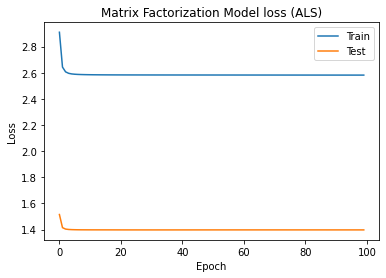

In [363]:
print("1. Matrix Factorization Model loss (ALS)")
print("-----"*8)
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Matrix Factorization Model loss (ALS)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()

Matrix Factorization Model loss (ALS) - Test Loss
--------------------------------------------------


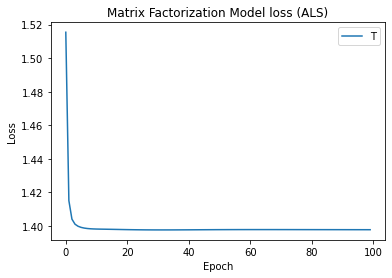

In [368]:
print("Matrix Factorization Model loss (ALS) - Test Loss")
print("-----"*10)
# plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Matrix Factorization Model loss (ALS)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc = 'best')
plt.legend('Test', loc = 'best')
plt.show()

Matrix Factorization Model loss (GD)
----------------------------------------


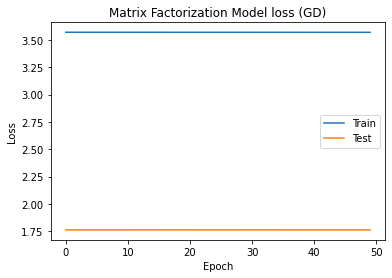

In [362]:
print("Matrix Factorization Model loss (GD)")
print("-----"*8)
plt.plot(train_losses_gd)
plt.plot(test_losses_gd)
plt.title('Matrix Factorization Model loss (GD)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
# plt.legend(['Test'], loc = 'best')
plt.show()

Matrix Factorization Model loss (GD) - Test Loss
--------------------------------------------------


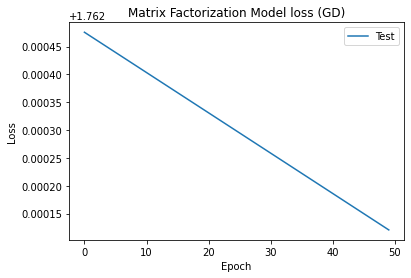

In [367]:
print("Matrix Factorization Model loss (GD) - Test Loss")
print("-----"*10)
# plt.plot(train_losses_gd)
plt.plot(test_losses_gd)
plt.title('Matrix Factorization Model loss (GD)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc = 'best')
plt.legend(['Test'], loc = 'best')
plt.show()

In [ ]:
print("2. Neural Network Model loss")
print("---"*8)
plt.plot(losses)
plt.title('Neural Netwrok Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'best')
plt.show()

#4. Top-5 recommended movies for a user

In [ ]:
# Function: returns a dataframe of unique movieIds
def get_list_of_all_movies(df_train):
  return pd.DataFrame(data=df_train['movieId'].unique(), columns=['movieId']) #movieIds 

movieIds = get_list_of_all_movies(train)

# Function: recommends movies
def recommend_movies(userID, df_movieIds, df_train, technique, n=5, df_preds_MF=None, model=None):

  """ Function: returns top-5 recommended movies for userID
      args:
          userID: userId in training set
          df_movieIds: all unique movies in the training set (DataFrame of all unique movieId's) 
          df_train: training set (DataFrame with at least three columns: userId, movieId, rating)
          technique: 'NN' for Neural Network and 'MF' for Matrix Factorization
          df_preds_MF: reconstructed matrix from matrix factorization if technique == 'MF'
          model: NN model if technique == 'NN'
  """

  user_row_number = userID - 1  #<<<<<<<<<<<<<< Needs revision

  if technique == 'MF':
    #1. get all best sorted movie ids
    sorted_user_predictions = df_preds_MF[df_preds_MF.index==userID].sort_values(by=userID, axis=1, ascending=False)
    sorted_user_predictions = pd.DataFrame(np.transpose(sorted_user_predictions.values), columns=sorted_user_predictions.index, index=sorted_user_predictions.columns)

  elif technique != 'NN':
    print("You must enter the 'technique' type correctly: 'MF' for Matrix Factorization or 'NN' for Neural Network")
    return;

  #2. >get watched movies by our user + sort them by rating
  movies_watched = df_train[df_train.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating

  #3. >get NOT watched movies by our user
  movies_not_watched = df_movieIds[~df_movieIds['movieId'].isin(movies_watched['movieId'])]

  if technique == 'NN':
    user = [userID] * len(movies_not_watched)
    new_movies = movies_not_watched['movieId'].tolist()

    user = torch.tensor(user).to(device=device, dtype=torch.long)
    new_movies = torch.tensor(new_movies).to(device=device, dtype=torch.long)

    rating_preds = model(user, new_movies).squeeze() # a list of predicted ratings
    new_movies = new_movies.cpu().detach().tolist()
    rating_preds = rating_preds.cpu().detach().tolist()
    data = {"movieId":new_movies, userID:rating_preds}
    sorted_user_predictions = pd.DataFrame(data)
  
  #4. get predictions for non-watched movies
  recommendations = (movies_not_watched).merge(
      pd.DataFrame(sorted_user_predictions).reset_index(),
      how = 'left', left_on = 'movieId', right_on = 'movieId').rename(
          columns = {userID: 'Predictions'}).sort_values(
              'Predictions', ascending = False).iloc[:n]
  
  if technique == 'NN':
    recommendations.drop(columns='index') 

  return movies_watched, recommendations

def predictMF(userID, P, Q, df_train):
  # Get the predictions from Matrix Factorization technique.
  y_predicted = P @ Q.T
  preds_df = pd.DataFrame(y_predicted, columns = df_movie_features.columns)

  # Get top 5 recommneded movies for user with id "330"
  y_test_df, y_predicted_df = recommend_movies(userID, movieIds, df_train, technique='MF', df_preds_MF=preds_df)

  return y_test_df, y_predicted_df

def predictNN(userID, model, df_train):
  # Get top 5 recommneded movies for user with id "330" with NN technique
  y_test_df, y_predicted_df = recommend_movies(userID, movieIds, df_train, technique='NN', model=model)

  return y_test_df, y_predicted_df

##1. Matrix Factorization

In [ ]:
userID = 330

In [347]:
#ALS
top_liked_by_user, new_predicted_to_user = predictMF(userID, P, Q, train)

In [38]:
print("****" * 8)
print(f"Top 5 liked movies by user {userID}")
print("****" * 8)

# 1/ Real Ratings
top_liked_by_user.head()

********************************
Top 5 liked movies by user 330
********************************


,userId,movieId,rating
32806,330,17,5.0
32948,330,588,5.0
32820,330,47,5.0
32894,330,296,5.0
32821,330,50,5.0


In [28]:
print("====" * 13)
print(f"Top 5 movie recommendations for user {userID} -- TEST SET")
print("====" * 13)
new_predicted_to_user_TRUE = test[test.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating
new_predicted_to_user_TRUE.head()

Top 5 movie recommendations for user 330 -- TEST SET


,userId,movieId,rating
8282,330,349,5.0
8253,330,110,5.0
8270,330,262,4.0
8289,330,421,4.0
8271,330,272,4.0


In [355]:
print("----" * 13)
print(f"Top 5 movie recommendations for user {userID} -- MF (ALS)")
print("----" * 13)

# 2/ Predicted Rating s
new_predicted_to_user.head()

----------------------------------------------------
Top 5 movie recommendations for user 330 -- MF (ALS)
----------------------------------------------------


,movieId,Predictions
170,457,2.987199
300,608,2.850280
472,349,2.155131
285,377,2.045778
132,480,2.032174


In [356]:
#GD
_, new_predicted_to_user = predictMF(userID, P2, Q2, train)

In [26]:
print("----" * 13)
print(f"Top 5 movie recommendations for user {userID} -- MF (GD)")
print("----" * 13)

# 2/ Predicted Rating s
new_predicted_to_user.head()

----------------------------------------------------
Top 5 movie recommendations for user 330 -- MF (GD)
----------------------------------------------------


,movieId,index,Predictions
2689,2937,2689,4.187989
2628,2351,2628,4.137471
1062,678,1062,4.104546
1362,58559,1362,4.100732
3793,3677,3793,4.096542


##2. Neural Network Model

In [ ]:
top_liked_by_user, new_predicted_to_user = predictNN(userID, model, train)

In [37]:
print("****" * 8)
print(f"Top 5 liked movies by user {userID}")
print("****" * 8)

# 1/ Real Ratings
top_liked_by_user.head()

********************************
Top 5 liked movies by user 330
********************************


,userId,movieId,rating
32806,330,17,5.0
32948,330,588,5.0
32820,330,47,5.0
32894,330,296,5.0
32821,330,50,5.0


In [36]:
print("====" * 13)
print(f"Top 5 movie recommendations for user {userID} -- TEST SET")
print("====" * 13)
new_predicted_to_user_TRUE = test[test.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating
new_predicted_to_user_TRUE.head()

Top 5 movie recommendations for user 330 -- TEST SET


,userId,movieId,rating
8282,330,349,5.0
8253,330,110,5.0
8270,330,262,4.0
8289,330,421,4.0
8271,330,272,4.0


In [ ]:
print("----" * 12)
print(f"Top 5 movie recommendations for user {userID} -- NN")
print("----" * 12)

# 2/ Predicted Rating s
new_predicted_to_user.head()

#BROUILLONS [x]

In [ ]:
#BROUILLONS
# for epoch in range(20):

#   for idx_user, p in enumerate(P): #a user latent vector 
#     for idx_item, p in enumerate(Q): #a movie latent vector
      
#       user_id = unique_users[idx_user]
#       item_id = unique_movies[idx_item]
      
#       user_row = train.loc[train['userId'] == user_id]
#       item =  user_row.loc[user_row['movieId'] == item_id]
                          
#       y = item['rating'].item()
#       y_pred = np.dot(p,q)

#       loss = squared_error_loss(y, y_pred, p, q)
#       print("Loss: ", loss)

#       loss.backward()


#       with torch.no_grad():


#         P.grad.zero_()
#         Q.grad.zero_()

# df_movie_features_sparse = csr_matrix(df_movie_features)
# from scipy.sparse import coo_matrix

# coo = coo_matrix(df_movie_features.values)
# values = torch.FloatTensor(coo.data)
# indices = torch.LongTensor(np.vstack((coo.row, coo.col)))
# shape = coo.shape

# # tensor = torch.sparse.FloatTensor(indices, values, torch.Size(shape))
# sparse_ratings_tensor_matrix = torch.sparse_coo_tensor(indices, values, torch.Size(shape))



# n_epochs = 20
# C = 0.5
# k = 50
# lr = 1e-3

# #user latent matrix
# P = torch.randn(U, k, device=device, dtype=torch.float64)  

# #item latent matrix
# Q = torch.randn(I, k, device=device, dtype=torch.float64)  

# #ratings dense matrix
# Y = torch.from_numpy(df_movie_features.values)

# for epoch in range(n_epochs):

#       # P=P−α(λP−((R-P*Q.T)∘M)Q)
#       Y_pred = P @ Q.T #inner dot products                 
#       error = Y-Y_pred
#       LOSS = squared_error_loss(error, C)
#       print(f"\nEpoch: {epoch}/{n_epochs}, LOSS = {LOSS.mean()}")
      
#       P -= (lr * (C*P - (error * M)   @ Q))
#       Q -= (lr * (C*Q - (error * M).T @ P))


      # bu -= (lr * (C*bu - error))
      # bi -= (lr * (C*bi - error.T))


In [ ]:
# def RMSE(error, A, B, C=0.2, bu=None, bi=None): 
        
#   squared_magnitude_P = (A @ A.T).sum()
#   squared_magnitude_Q = (B @ B.T).sum()

#   squared_magnitude_bu = 0
#   squared_magnitude_bi = 0

#   if (bu is not None and bi is not None):
#     squared_magnitude_bu = (bu @ bu.T).sum()
#     squared_magnitude_bi = (bi @ bi.T).sum()

#   regularization = C*(squared_magnitude_P + squared_magnitude_Q + squared_magnitude_bu + squared_magnitude_bi)
#   loss = ((error**2).sum() + regularization)/(total_ratings)
#   loss = np.sqrt(loss)                                                                   
#   # Note: total_ratings or |u,i| is the total number of ratings in the dataset.

#   return loss